# Example of GITIII usage in the Alzheimer's disease (AD) dataset

In this tutorial, we demonstrate the functionalities of the cell-cell interaction (CCI) analyzing tool GITIII in:
1. Estimating the influence tensor that describe how each cell is influenced by its top k (default 50) nearest neighbors
2. Visualizing the relationship between the strength of interaction with the distance between two cells
3. Visualizing the functions of CCI pairs using UMAP: the pair of one sender cell influencing one receiver cell is called a CCI pair, and the estimated influence from the sender cell to the receiver cell (how much the gene expression in the receiver cell would change because of the existing of the sender cell) are treated as the features of the CCI pair. This function aim to visualize how different CCI pairs belonging to different cell type combinations differ from each other in terms of their functions
4. Prediction visualization: visualize the predicted cell expression v.s. predicted expression, can be state expression (have negative values) or raw expression (>0)
5. Information flow: Where are the strongest CCI pairs in the slide (tissue section), with arrows in the plot indicating the interaction from one sender cell to one receiver cell
6. Cell subtyping analysis: We first construct interpretable CCI-informed features for each cell, (how each cell type influence each measured genes in this cell), use these features to do Leiden clustering and UMAP visualization. Then differential expressed gene (DEG) analysis can be performed on these subtypes (subgroups), and we can also visualize how this cell ('s one target gene) is influenced by other cell types via heatmap.
7. Network analysis: Using partial linear regression to make statistical test of whether one cell type significantly influence one gene in the receiver cell type, forming a significant CCI network targeting each gene.

**It would roughly take 1.5 hours for the computer to run all the codes in this tutorial (under the selected batch size and A5000 24G GPU, the computing resources demands are CPU memory >= 64G and GPU memory >= 8G).**

# Data downloading

The data used in this section is the SEA-AD dataset, which contains data from 366,272 cells across 69 images of the human middle temporal gyrus from 27 donors, obtained using MERFISH. The dataset includes the measurements of 140 genes, and we utilized the 24 "subclass" cell type annotation from the original study. For demonstration, we used the sample 'H20.33.001.CX28.MTG.02.007.1.02.03' (Figure 3a, 3b) to illustrate within-sample heterogeneity.

A processed dataset is available at https://drive.google.com/file/d/1KYpkDZHOlVJXZzKrfMbyyOl42syylw90/view?usp=sharing

Suppose the data is downloaded at the working directory with name "./AD.csv"

If you want to use your own data, the dataframe you input should have the following columns:

- genes (more than one column), as described below, these columns form the expression matrix. Values in these columns must be int or float
- "centerx": x coordinates of the cells. int or float
- "centery": y coordinates of the cells. int or float
- "section": which tissue slide this cell belongs to, since a dataset may contain more than one slide. string
- "subclass": the cell type annotation for this cell. string

You also need a list of measured genes in the dataset, like the code block below:

In [1]:
genes=['PRRT4', 'GRIP2', 'FOXP2', 'PDZD2', 'KIAA1217', 'PALMD', 'LRRC4C', 'ASIC2', 'NPAS3', 'LUZP2', 'GRIN2A', 'NLGN1', 'NTNG2', 'TACR1', 'PDGFD', 'ANK1', 'DLX1', 'CBLN2', 'ZNF804A', 'CACNA2D3', 'CDH6', 'CD22', 'ETNPPL', 'CALB1', 'TSHZ2', 'FGF13', 'KIRREL3', 'ROBO1', 'RBFOX3', 'ASTN2', 'ID3', 'TH', 'TENM2', 'ZMAT4', 'CLSTN2', 'SEMA6D', 'HPSE2', 'BTBD11', 'LRP1B', 'NOS1', 'GPC5', 'SNTB1', 'COL11A1', 'TMEM255A', 'SATB2', 'SORCS3', 'FBXL7', 'GRM8', 'GALNTL6', 'NOSTRIN', 'DCC', 'SOX6', 'MEIS2', 'STXBP6', 'SMYD1', 'SCUBE1', 'LAMA4', 'CNTN5', 'GRM7', 'KCNMB2', 'CUX2', 'LAMP5', 'SLIT3', 'TAFA1', 'PRKG1', 'CSMD1', 'CNTNAP5', 'NFIA', 'FRMPD4', 'GRID2', 'HS6ST3', 'SORCS1', 'ATRNL1', 'ADAMTS3', 'SLC24A2', 'RBFOX1', 'TMEM132D', 'NKAIN2', 'PEX5L', 'TNR', 'DGKG', 'RFX3', 'UNC5B', 'HTR2A', 'RGS12', 'CACHD1', 'RORB', 'LRRK1', 'THEMIS', 'CARTPT', 'SLC32A1', 'GAD2', 'MOG', 'DCN', 'TOX', 'ZNF385D', 'PDE4B', 'GRIP1', 'ITGB8', 'PLD5', 'NPY', 'NDNF', 'SEMA3E', 'KAZN', 'DLC1', 'PLCB1', 'HCN1', 'ITGA8', 'EBF1', 'PRRX1', 'SLC14A1', 'EGFR', 'FEZF2', 'PAX6', 'ROBO2', 'SV2C', 'DCLK1', 'EYA4', 'RYR3', 'L3MBTL4', 'GRIN3A', 'CD74', 'RGS6', 'CTSS', 'KCNIP4', 'DACH1', 'HTR2C', 'PVALB', 'HS3ST2', 'GRIK3', 'FGF12', 'LHX6', 'VIP', 'CA10', 'ADAMTSL1', 'CHODL', 'SULF1', 'NRG1', 'NXPH2', 'TLL1']

# Initialize the influence tensor estimator

In [2]:
# Import necessary python packages
import gitiii

estimator=gitiii.estimator.GITIII_estimator(df_path="./AD.csv",genes=genes,use_log_normalize=True,species="human",use_nichenetv2=True,visualize_when_preprocessing=False,distance_threshold=80,process_num_neighbors=50,num_neighbors=50,batch_size_train=256,lr=1e-4,epochs=50,node_dim=256,edge_dim=48,att_dim=8,batch_size_val=256,use_cell_type_embedding=True)

## Introduction of the parameters used in the code block above:

**Except for `df_path`, `genes`, `use_log_normalize`, and `species`, you can feel good to use all other hyperparameters by default as shown above, so generally speaking, you only need to fill in 4 parameters and prepare your own dataset and all other steps will be done automatically**

### Data you must input:

:param `df_path`: str, the path of your dataset, which should be a .csv file with columns of:
- genes (more than one column), as described below, these columns form the expression matrix.
            values in these columns must be int or float
- "centerx": x coordinates of the cells. int or float
- "centery": y coordinates of the cells. int or float
- "section": which tissue slide this cell belongs to, since a dataset may contain more than one slide. string
- "subclass": the cell type annotation for this cell. string

:param `genes`: list of str, a python list of measured gene names in the dataset

:param `use_log_normalize`: bool, whether to perform log-normalization log2(x+1) here for the expression matrix

- Attention: If you would like to use your own way of data normalization or have already normalized your expression matrix in the dataframe, choose False

:param `species`: str, what is the species of your dataset, must be one of "human" or "mouse"

---

### Hyperparameter settings (you can use the default one):

:param `use_nichenetv2`: bool, whether or not to include the ligands from nichenetv2, if not, only ligand-receptor pair from cellchat and neuronchat will be used

:param `visualize_when_preprocessing`: bool, whether to visualize the ST dataset when preprocessing

:param `distance_threshold`: float or int, if the distance between one cell and its nearest neighbor isabove this threshold, then we think this cell is moved during the preparation of the tissue slide in the wet lab experiment, we would not include this cell in the analysis

:param `process_num_neighbors`: int, how many k-nearest neighbor are needed to be calculated in preprocessing

:param `num_neighbors`: int, number of neighboring cells used to predict the cell state of the center cell

:param `batch_size_train`: int, batch size at the training step

:param `lr`: learning rate, float

:param `epochs`: int, number of training rounds

:param `node_dim`: int, embedding dimension for node in the graph transformer

:param `edge_dim`: int, embedding dimension for edge in the graph transformer

:param `att_dim`: int, dimension needed to calculate for one-head attention

:param `batch_size_val`: int, batch size at the evaluating step

:param `use_cell_type_embedding`: bool, whether to use cell type embedding in the embedding part, default True, if you have many rare cell types (cell types with low frequency), then use False.

# Preprocess the dataset

This includes calculating the top 50 nearest neighbor for each cell, splitting the cell type expression and cell state expression, this step only use CPU and takes about 15 minutes. 

For the next 3 step, I recommend to use script instead of using interactive software like jupyter notebook since it would took hours to finish.

In [3]:
estimator.preprocess_dataset()

There are 24 ligands measured in this dataset
Doing log2(x+1) tranform
Finish doing log2(x+1) tranform
Splitting cell type expression and cell state expression
All variance 0.4773031954125574 type_variance 0.17218897255697638 0.3607538650734251 state_variance 0.30511422285571194 0.6392461349268492
Finish splitting cell type expression and cell state expression
processing: H20.33.001.CX28.MTG.02.007.1.02.02
Select 7937 cells from 7938 cells
processing: H20.33.001.CX28.MTG.02.007.1.02.03
Select 15222 cells from 15225 cells
processing: H20.33.001.Cx28.MTG.02.007.1.01.03
Select 6680 cells from 6680 cells
processing: H20.33.004.Cx26.MTG.02.007.1.01.04
Select 5323 cells from 5333 cells
processing: H20.33.004.Cx26.MTG.02.007.1.01.05
Select 3157 cells from 3158 cells
processing: H20.33.004.Cx26.MTG.02.007.1.02.02
Select 4120 cells from 4125 cells
processing: H20.33.004.Cx26.MTG.02.007.1.02.03
Select 4709 cells from 4709 cells
processing: H20.33.004.Cx26.MTG.02.007.1.02.04
Select 6594 cells fro

# Train the deep learning model

This step require GPU, the batch_size and model hyperparameter in the above default estimator hyperparameters roughly require 5G GPU memory, if you want it to train faster, you can increase the batch_size.

The training takes about 1 hours in this dataset (366,272 cells, 140 genes) with A5000 24G. The model converges at about 20-th epoch, and the software will automatically save the best model with the lowest mean square error on the validation set.

For your own dataset, the computation time would increase linearly with the number of cells in the dataset and sqrt(number of measured genes in the dataset).

In [4]:
estimator.train()

Start loading the dataset
Have samples: 69 ['H20.33.001.CX28.MTG.02.007.1.02.02', 'H20.33.001.CX28.MTG.02.007.1.02.03', 'H20.33.001.Cx28.MTG.02.007.1.01.03', 'H20.33.004.Cx26.MTG.02.007.1.01.04', 'H20.33.004.Cx26.MTG.02.007.1.01.05', 'H20.33.004.Cx26.MTG.02.007.1.02.02', 'H20.33.004.Cx26.MTG.02.007.1.02.03', 'H20.33.004.Cx26.MTG.02.007.1.02.04', 'H20.33.012.Cx24.MTG.02.007.1.01.01', 'H20.33.012.Cx24.MTG.02.007.1.03.02', 'H20.33.012.Cx24.MTG.02.007.1.03.03', 'H20.33.015.CX24.MTG.02.007.1.03.01', 'H20.33.015.CX24.MTG.02.007.1.03.02', 'H20.33.015.Cx24.MTG.02.007.1.03.03', 'H20.33.025.Cx28.MTG.02.007.1.01.02', 'H20.33.025.Cx28.MTG.02.007.1.01.04', 'H20.33.025.Cx28.MTG.02.007.1.01.06', 'H20.33.035.Cx26.MTG.02.007.1.01.03', 'H20.33.035.Cx26.MTG.02.007.1.01.04', 'H20.33.040.Cx25.MTG.02.007.1.01.03', 'H20.33.040.Cx25.MTG.02.007.1.01.04', 'H20.33.044.Cx26.MTG.02.007.1.01.02', 'H20.33.044.Cx26.MTG.02.007.1.01.03', 'H20.33.044.Cx26.MTG.02.007.1.01.04', 'H21.33.001.Cx22.MTG.02.007.1.01.03', 'H21.3

# Calculate the influence tensor

This step require GPU, it would take about 2-10 minutes, be sure to have a large CPU memory (~100G, not GPU memory) if you have tissue sections that have many cells (>80000)

In [5]:
estimator.calculate_influence_tensor()

Start calculating the influence tensor, now loading pretrained model
Start calculating the influence tensor
0 / 69
Now calculating the influence tensor of: H20.33.001.CX28.MTG.02.007.1.02.02
Have samples: ['H20.33.001.CX28.MTG.02.007.1.02.02']
There are totally 7937 cells in this dataset
Finish H20.33.001.CX28.MTG.02.007.1.02.02
1 / 69
Now calculating the influence tensor of: H20.33.001.CX28.MTG.02.007.1.02.03
Have samples: ['H20.33.001.CX28.MTG.02.007.1.02.03']
There are totally 15222 cells in this dataset
Finish H20.33.001.CX28.MTG.02.007.1.02.03
2 / 69
Now calculating the influence tensor of: H20.33.001.Cx28.MTG.02.007.1.01.03
Have samples: ['H20.33.001.Cx28.MTG.02.007.1.01.03']
There are totally 6680 cells in this dataset
Finish H20.33.001.Cx28.MTG.02.007.1.01.03
3 / 69
Now calculating the influence tensor of: H20.33.004.Cx26.MTG.02.007.1.01.04
Have samples: ['H20.33.004.Cx26.MTG.02.007.1.01.04']
There are totally 5323 cells in this dataset
Finish H20.33.004.Cx26.MTG.02.007.1.01.04

# Visualize the spatial patterns

Here, we choose the tissue section (sample) 'H20.33.001.CX28.MTG.02.007.1.02.03' for demonstration

For analysis that you want to target a specific gene, we use "RORB" for demonstration

**Please pay attention that only gene that are measured in the dataset can be used, otherwise there would be error**

In [6]:
sample='H20.33.001.CX28.MTG.02.007.1.02.03'

spatial_visualizer=gitiii.spatial_visualizer.Spatial_visualizer(sample=sample)

Start loading data
There are 15222 cells in this sample
Finish loading data


## Visualize the relationship between \[the averaged interaction strength between two cells\] with \[the distance between two cells\]

Estimate the distance scaler and visualize it, x-axis is distance or the rank of nearest neighbor,
        the y-axis can be proportional influence or the abs value of influence
        
:param `rank_or_distance`: x axis is distance or the order (rank) of nearest neighbor

:param `proportion_or_abs`: use the proportional influence (for each cell's each gene, the influence are all
            positive values that sum up to 1) or the abs value of interaction
            
:param `target_gene`: if None, calculate the distance scaler averaged over all target genes

:param `bins`, frac: parameters used of calculating and plot losses.

For example:

### The averaged abs value of interaction strength v.s. distance between two cells

loss: tensor(0.2243)
random: tensor(0.2532)
first 5: tensor(0.2404)
first 10: tensor(0.2371)
first 20: tensor(0.2317)


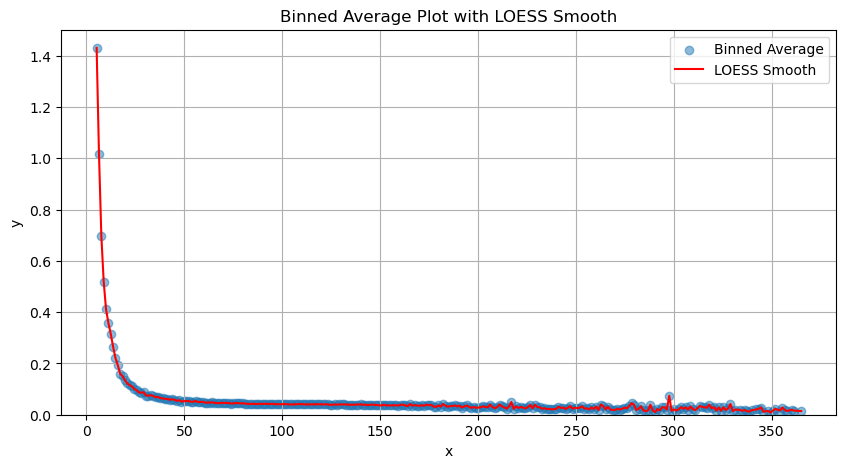

In [7]:
spatial_visualizer.plot_distance_scaler(rank_or_distance="distance",proportion_or_abs="abs",target_gene=None,bins=300, frac=0.003)

### The averaged abs value of interaction strength v.s. the order of nearest neighbor targeting gene "RORB"

loss: tensor(0.2243)
random: tensor(0.2532)
first 5: tensor(0.2404)
first 10: tensor(0.2371)
first 20: tensor(0.2317)


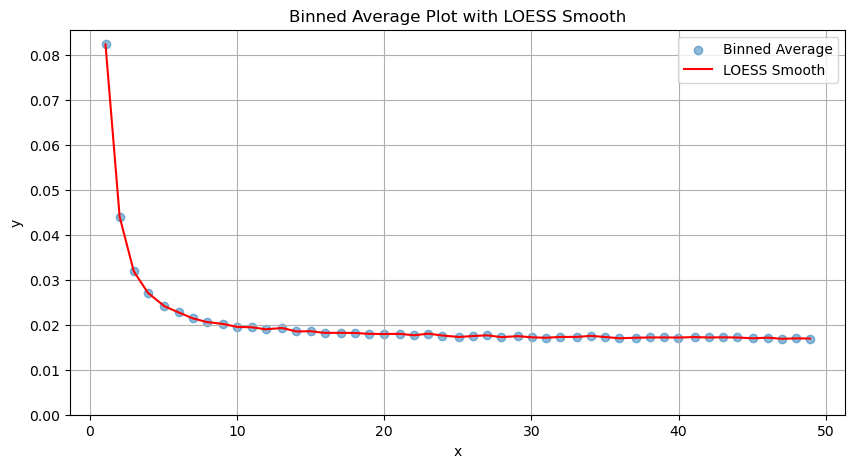

In [8]:
spatial_visualizer.plot_distance_scaler(rank_or_distance="rank",proportion_or_abs="proportion",target_gene="RORB",bins=300, frac=0.003)

## UMAP visualization of function of CCI pairs

Visualizing the functions of CCI pairs using UMAP: the pair of one sender cell influencing one receiver cell is called a CCI pair, and the estimated influence from the sender cell to the receiver cell (how much the gene expression in the receiver cell would change because of the existing of the sender cell) are treated as the features of the CCI pair. This function aim to visualize how different CCI pairs belonging to different cell type combinations differ from each other in terms of their functions

:param `select_topk`: For each receiver cell, how many strongest CCI pair should be selected for visualize
            one point on the UMAP is one CCI pair
            
:param `num_type_pair`: How many most frequent CCI type pair combination to show, since we can not demonstrate all cell_type_number*cell_type_number cell type combinations, there are too many colors

number of cell types in this sample: (array(['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT',
       'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b',
       'Lamp5', 'Lamp5 Lhx6', 'Microglia-PVM', 'OPC', 'Oligodendrocyte',
       'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype='<U15'), array([1523,   32,  799,  926, 1028,   79,  700,  104,  281,  810, 1087,
        444,  141,  125, 2541,  646, 2671,   23,  235,   42,  173,   15,
        643,  154]))
selecting edge types: ['Astrocyte->Oligodendrocyte' 'L6 IT Car3->Oligodendrocyte' 'L5 IT->L4 IT'
 'Microglia-PVM->Oligodendrocyte' 'Astrocyte->Microglia-PVM'
 'L6 IT->Oligodendrocyte' 'L6 IT Car3->Microglia-PVM' 'L6 IT->L6 IT Car3'
 'Oligodendrocyte->Microglia-PVM' 'L6 IT->Microglia-PVM']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/gitiii/spatial_visualizer.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag = [adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warnin

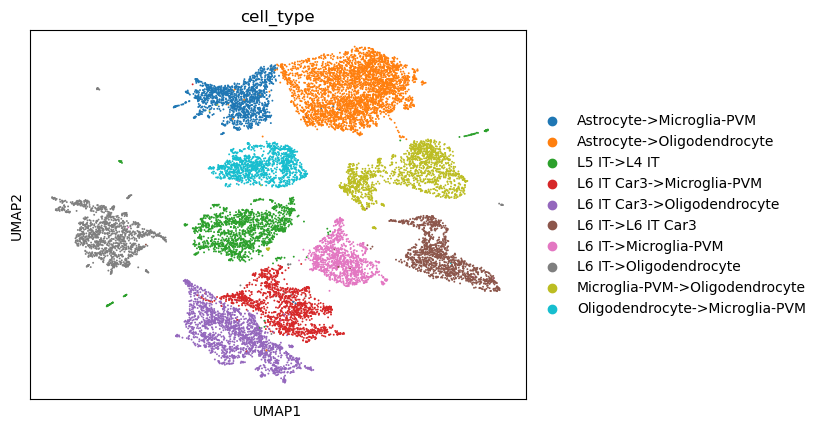

selecting edge types: ['Astrocyte->Oligodendrocyte' 'L6 IT Car3->Oligodendrocyte' 'L5 IT->L4 IT'
 'Microglia-PVM->Oligodendrocyte' 'Astrocyte->Microglia-PVM'
 'L6 IT->Oligodendrocyte' 'L6 IT Car3->Microglia-PVM' 'L6 IT->L6 IT Car3'
 'Oligodendrocyte->Microglia-PVM' 'L6 IT->Microglia-PVM']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/gitiii/spatial_visualizer.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag = [adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


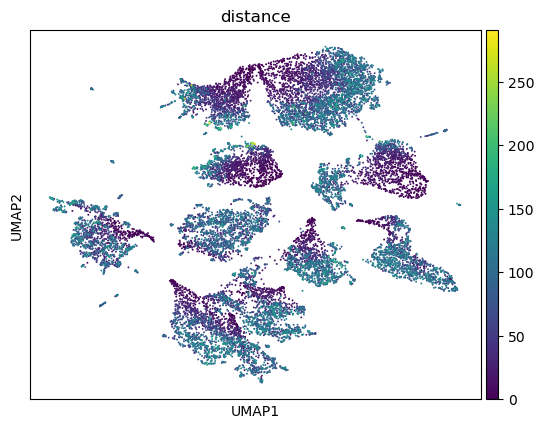

In [9]:
spatial_visualizer.visualize_CCI_function(select_topk=5,num_type_pair=10)

## Prediction visualization

Visualize the predicted cell expression v.s. predicted expression, can be state expression (have negative values) or raw expression (>0)

Now plotting predicted expression v.s. real expression


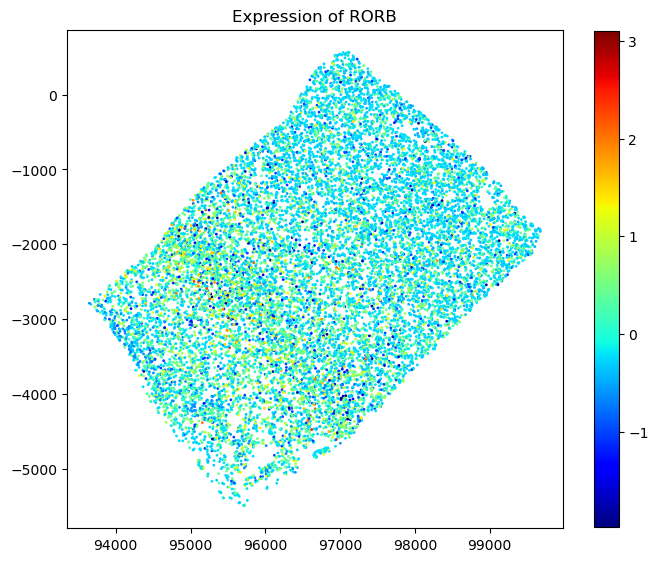

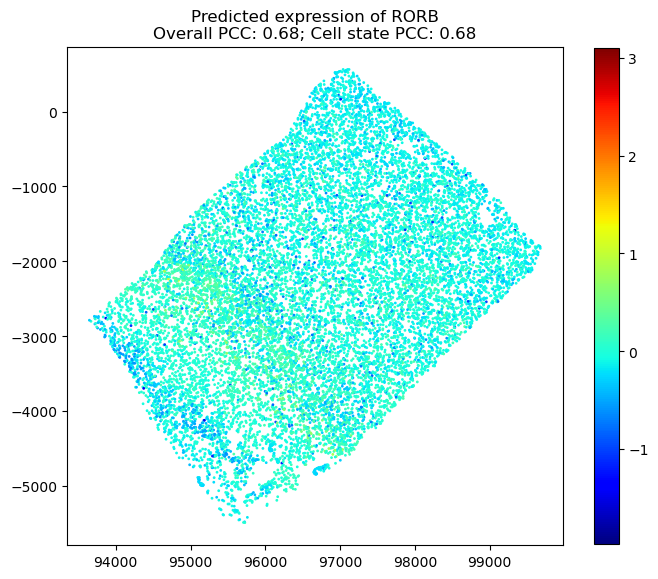

In [10]:
# Plot predicted expression (predicted cell state expression plus known cell type expression) v.s. real expression
spatial_visualizer.visualize_prediction(target_gene="RORB",plot_state=False)

Now plotting predicted cell state expression v.s. real cell state expression


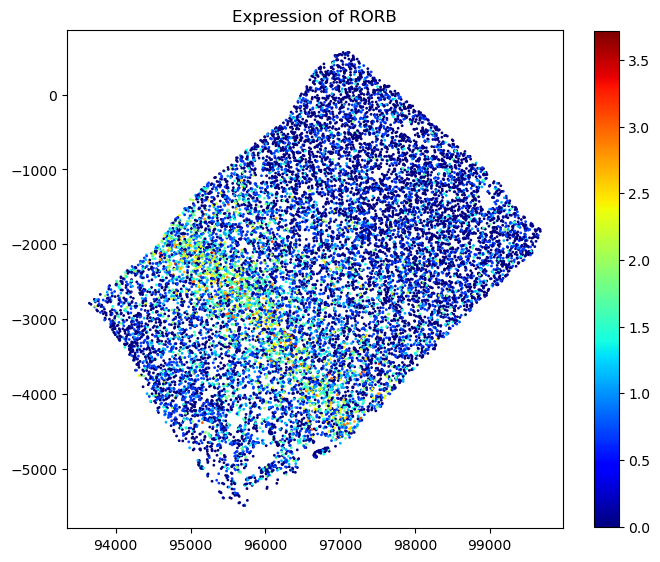

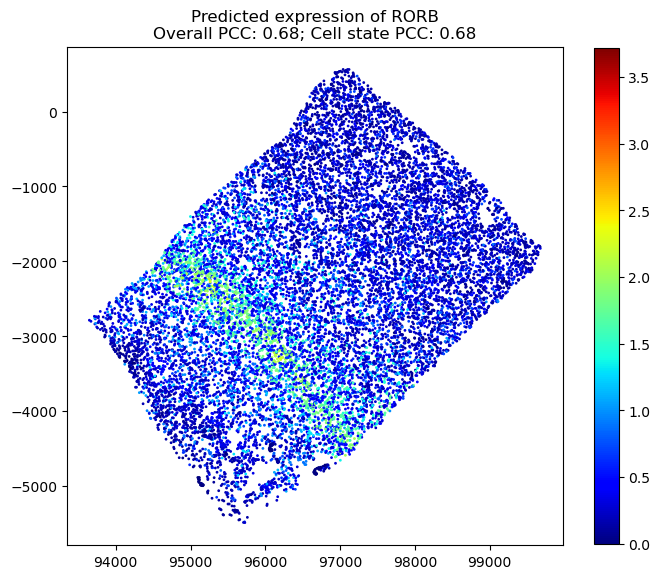

In [11]:
# Plot predicted cell state expression v.s. real cell state expression
spatial_visualizer.visualize_prediction(target_gene="RORB",plot_state=True)

## Information flow visualization
We want to find where are the strongest CCI pairs in the slide (tissue section), with arrows in the plot indicating the interaction from one sender cell to one receiver cell

:param target_gene: the information flow with respect to which gene you would like to visualized

:param select_topk: similar as before

:param use_neuron_layer: In the plot, whether to generalize the cell types to only excitatory neurons at
            different layers and Not_excitatory_neuron, by doing this, the plot may just look more layer-organized.
            
:param cutoff: In percentage, how many top CCI pairs out of select_topk*number_of_cell pairs to visualize.

number of cell types in this sample: (array(['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT',
       'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b',
       'Lamp5', 'Lamp5 Lhx6', 'Microglia-PVM', 'OPC', 'Oligodendrocyte',
       'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype='<U15'), array([1523,   32,  799,  926, 1028,   79,  700,  104,  281,  810, 1087,
        444,  141,  125, 2541,  646, 2671,   23,  235,   42,  173,   15,
        643,  154]))


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/gitiii/spatial_visualizer.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_x = from_x[flag]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/gitiii/spatial_visualizer.py:322: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_y = from_y[flag]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/gitiii/spatial_visualizer.py:323: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

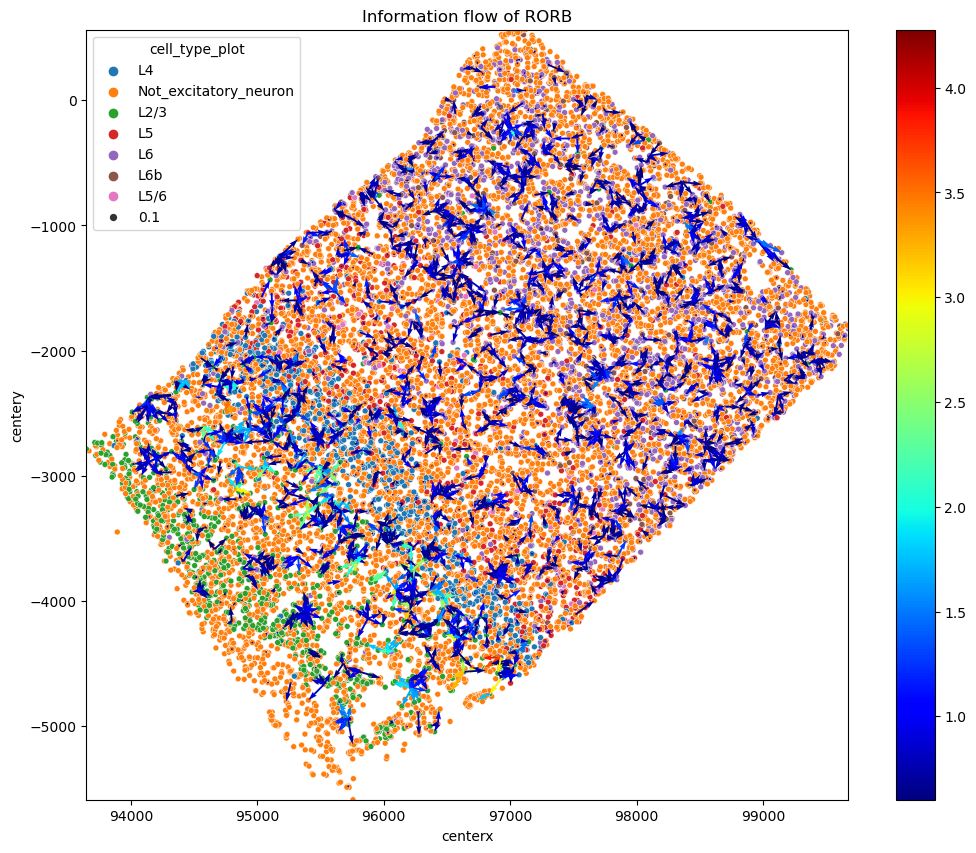

In [12]:
spatial_visualizer.visualize_information_flow(target_gene="RORB",select_topk=5,use_neuron_layer=True,cutoff=0.05)

# Cell subtyping analysis

We first construct interpretable CCI-informed features for each cell, (how each cell type influence each measured genes in this cell), use these features to do Leiden clustering and UMAP visualization. Then differential expressed gene (DEG) analysis can be performed on these subtypes (subgroups), and we can also visualize how this cell ('s one target gene) is influenced by other cell types via heatmap.

:param `sample`: which tissue slide to analyze

---

**You can tune the following hyperparameter to get a good subtyping results that you may want to see, different methods vary a lot**

:param `normalize_to_1`: whether normalize the aggregated influence tensor so that their abs value sum
        up to one on the second dimension
        
:param `use_abs`: whehter to use the absolute value for the aggregated influence tensor for downstream
        analysis
        
:param `noise_threshold`: For values in the influence tensor, if its corresponding proportional influence is less than this threshold,
        we would treat it as noise, ignore it by setting it to 0

Start loading data
Finish loading data
Start aggregating
0 / 15222
500 / 15222
1000 / 15222
1500 / 15222
2000 / 15222
2500 / 15222
3000 / 15222
3500 / 15222
4000 / 15222
4500 / 15222
5000 / 15222
5500 / 15222
6000 / 15222
6500 / 15222
7000 / 15222
7500 / 15222
8000 / 15222
8500 / 15222
9000 / 15222
9500 / 15222
10000 / 15222
10500 / 15222
11000 / 15222
11500 / 15222
12000 / 15222
12500 / 15222
13000 / 15222
13500 / 15222
14000 / 15222
14500 / 15222
15000 / 15222
Finish aggregating


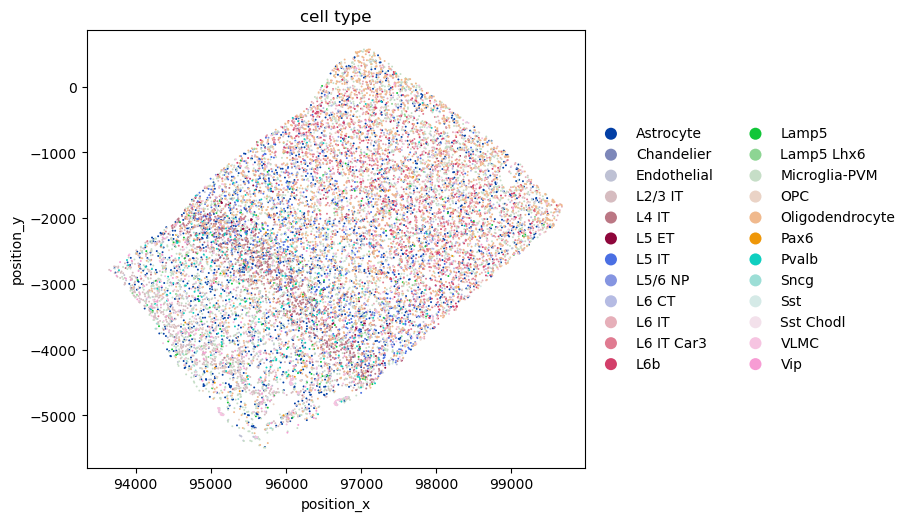

In [13]:
subtyping_analyzer=gitiii.subtyping_analyzer.Subtyping_anlayzer(sample=sample,normalize_to_1=True,use_abs=True,noise_threshold=2e-2)

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


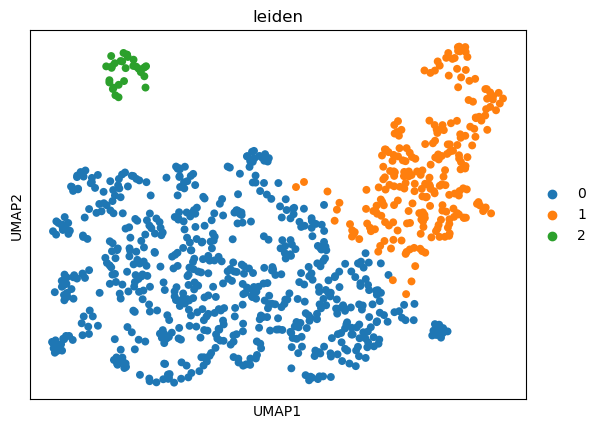

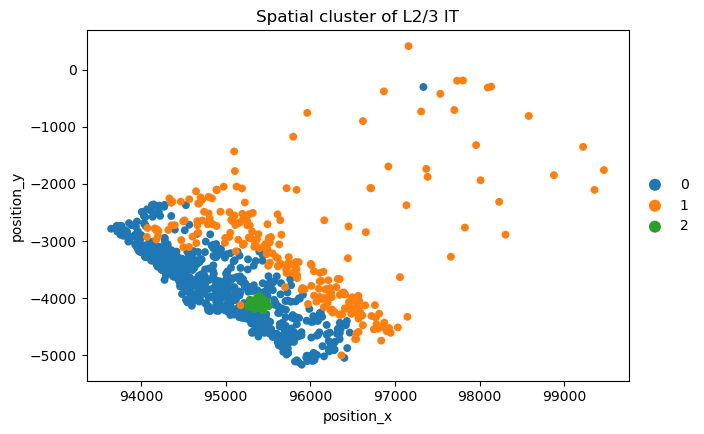

In [14]:
# Take L2/3 IT as an example for CCI informed subtyping analysis
COI="L2/3 IT" # Cell Of Interest
subtyping_analyzer.subtyping(COI=COI,resolution=0.1)

## Differential expressed gene analysis for the subgroups

function: subtyping_filter_groups(group_to_remain):

:param `group_to_remain`: list of str, for example, if you want to just analyze or compare the
            0-the group and 1-th group, as shown on the UMAP in subtyping analysis, you can make
            group_to_remain=\["1","0"\], be aware that the items in the list are not int, they are str

function: subtyping_DE(method='wilcoxon',n_gene_show=5)

:param `method`: statistical method to make comparison using scanpy, default to 'wilcoxon' (rank-sum test), other available methods are: 'logreg', 't-test', 'wilcoxon', 't-test_overestim_var'

:param `n_gene_show`: how many DE gene to plot for one subgroup

         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


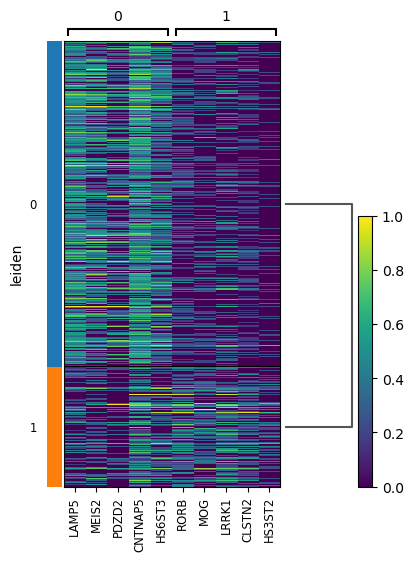

In [15]:
# We only want to compare the subgroup 0 and subgroup 1, so we do this
subtyping_analyzer.subtyping_filter_groups(["0","1"])

subtyping_analyzer.subtyping_DE()

## Analyze, proportionally, how each cell in each subgroup influenced by other cell types

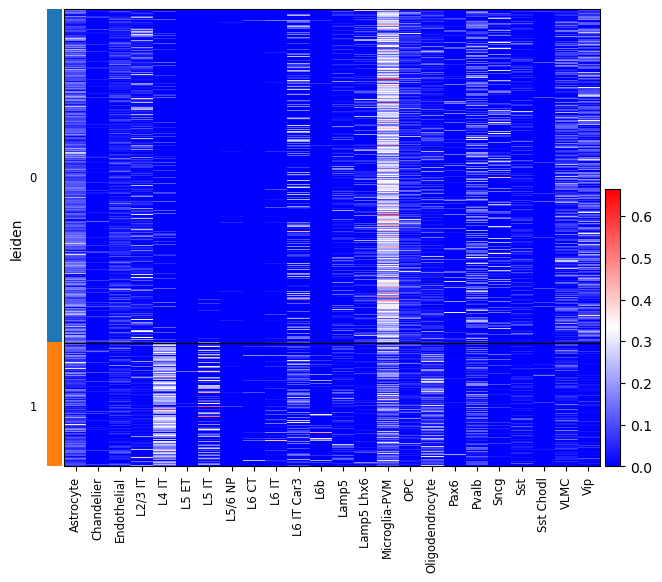

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


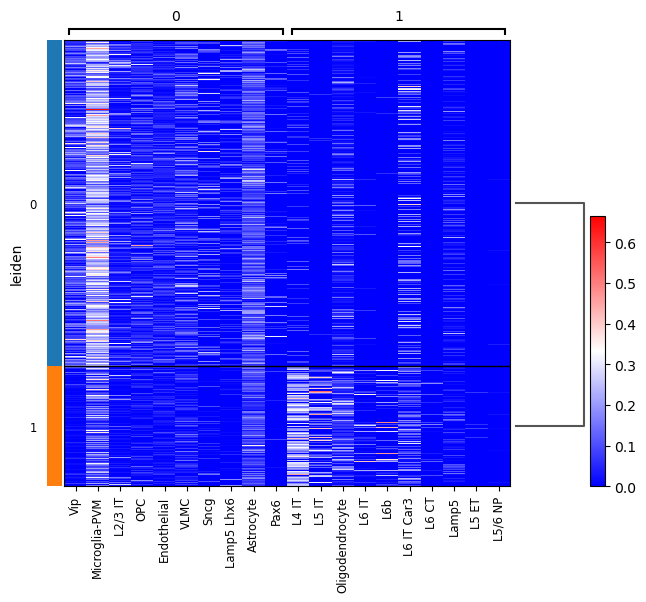

In [16]:
subtyping_analyzer.subtyping_get_aggregated_influence()

Or, if we just want to look at the proportional influence targeting one gene, like RORB.

And if you also want to know if it is up-regulated or down-regulated by other cell types, be sure to have use_abs=True in subtyping_analyzer=gitiii.subtyping_analyzer.Subtyping_anlayzer

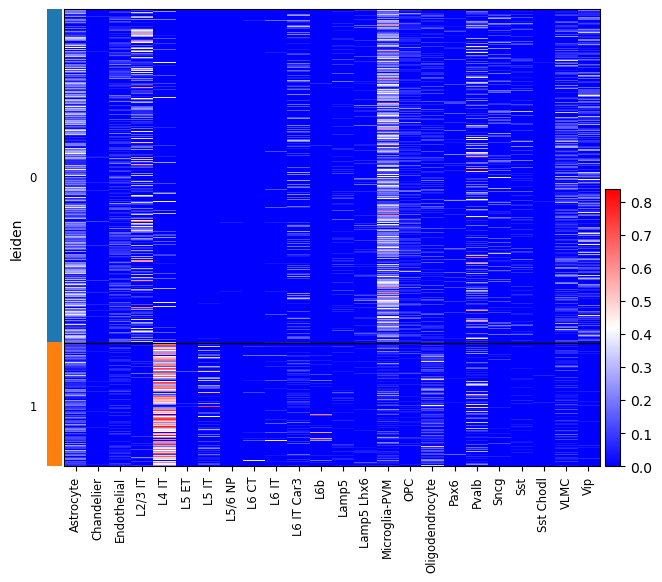

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


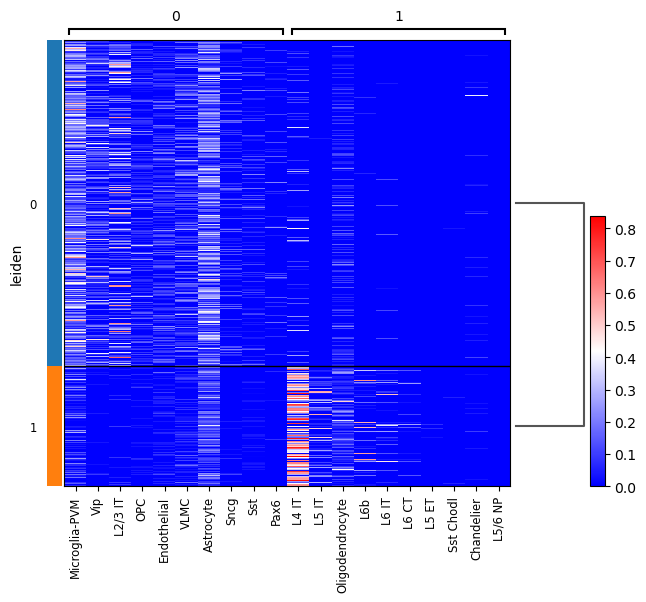

In [17]:
subtyping_analyzer.subtyping_get_aggregated_influence_target_gene(target_gene="RORB")

# Network analysis

Using partial linear regression to make statistical test of whether one cell type significantly influence one gene in the receiver cell type, forming a significant CCI network targeting each gene.

:param `noise_threshold`: For values in the influence tensor, if its corresponding proportional influence is less than this threshold,
        we would treat it as noise, ignore it by setting it to 0

In [18]:
network_analyzer=gitiii.network_analyzer.Network_analyzer(noise_threshold=2e-2)

Start loading data
Finish loading data


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/gitiii/network_analyzer.py:10: UserWarning: Network visualization is performed using R, this function only calculate the z-score matrix of significant CCI network for each sample
  warnings.warn("Network visualization is performed using R, "


## Calculate the z-scores for the significant CCI network for one sample

In [19]:
network_analyzer.determine_network_sample(sample=sample)

Lamp5 Lhx6 Pax6 23
tensor(1.) tensor(inf) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0821, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000]) tensor([-0.1130, -0.1130, -0.1130, -0.1130, -0.1130,  0.5801, -0.1130, -0.1130,
        -0.1130, -0.1130, -0.1130, -0.1130, -0.1130, -0.1130, -0.1130, -0.1130,
        -0.1130, -0.1130, -0.1130, -0.1130, -0.1130, -0.1130, -0.1130])
Pvalb Sst Chodl 15
tensor(1.) tensor(inf) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1148, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]) tensor([-0.0115, -0.0115, -0.0115, -0.0115, -0.0115, -0.0115, -0.0115,  0.6817,
        -0.0115, -0.0115, -0.0115, -0.0115, -0.0115, -0.0115, -0.0115])
Sst Chodl Pax6 23
tensor(1.) tensor(inf) tensor([0.3162, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

array([[-2.07931495, -0.98550749, -1.4456923 , ..., -2.37767744,
        -1.55229115, -0.12929386],
       [-0.08026263, -1.68640399,  1.91002095, ..., -0.14404015,
        -0.3797622 ,  0.        ],
       [-1.24601543, -2.79879785, -0.06953474, ...,  1.61922848,
        -0.45121145, -1.0608629 ],
       ...,
       [-0.46899456, -0.4636707 , -1.26273739, ..., -0.20997737,
         0.40547821, -0.5768488 ],
       [ 0.98985738, -1.67368126,  1.79655921, ...,  0.16402079,
        -0.44539011, -0.8032251 ],
       [ 0.61411929, -0.02015239, -0.72729021, ..., -0.6307832 ,
         1.08423257,  2.78019452]])

## Or if you want to calculate the significant CCI network for all samples

In [20]:
network_analyzer.determine_networks()

L5 ET Chandelier 17
tensor(1.) tensor(inf) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0681, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]) tensor([-0.2763, -0.2763, -0.2763, -0.2763, -0.2763, -0.2763, -0.2763, -0.2763,
        -0.2763, -0.2763, -0.2763,  0.4168, -0.2763, -0.2763, -0.2763, -0.2763,
        -0.2763])
L6 IT Car3 Sst Chodl 14
tensor(1.) tensor(inf) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3521, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000]) tensor([-0.0874, -0.0874, -0.0874, -0.0874,  0.6058, -0.0874, -0.0874, -0.0874,
        -0.0874, -0.0874, -0.0874, -0.0874, -0.0874, -0.0874])
L6 IT Car3 Sst Chodl 14
tensor(1.) tensor(inf) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3308, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000]) tensor([-0.2164, -0.2164, -0.2164, -0.2164,  0.4768, -0.2164, -0.2164, -0.2164,
        -0.2164, -0.2164, -0.2164, -0.2164, -0.2164

## Calculate the counts for one sample and all samples

In [21]:
# for one sample
network_analyzer.get_counts_sample(sample=sample)
# for all samples
network_analyzer.get_counts()

Sst Chodl not in H20.33.035.Cx26.MTG.02.007.1.01.04 with cell types: ['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Lamp5 Lhx6', 'Microglia-PVM', 'OPC', 'Oligodendrocyte', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'VLMC', 'Vip']
Sst Chodl not in H21.33.006.Cx28.MTG.02.007.1.01.09.02 with cell types: ['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Lamp5 Lhx6', 'Microglia-PVM', 'OPC', 'Oligodendrocyte', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'VLMC', 'Vip']
